# Testing bias metrics and mitigation algorithms on a Synthetic dataset

The goal of this analysis is to make a comparison of different bias mitigation methods for classification problems on different types of dataset and to see how these methods impact on different fairness metrics and on the accuracy of the classifier. The datasets on which we will test the fairness algorithms are:

1. Unbias dataset
2. Bias unbalanced dataset
3. Bias balanced dataset

In [1]:
# import libraries
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from Sampler import Sampler
from utility import *
sns.set_theme()

## Dataset fairness metrics definition

The group fairness metrics related to the dataset are defined as follows:

- **Disparate impact**

$$
\frac{Pr(Y=1|S=unprivileged)}{Pr(Y=1|S=privileged)}
$$

> If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data

- **Statistical parity**

$$
Pr(Y=1|S=unprivileged)-Pr(Y=1|S=privileged)
$$

## Classifier fairness metrics definition

The group fairness metrics related to the classifier are defined below:

- **Balanced Accuracy**

$$
\frac{TP + TN}{2}
$$

- **Statistical parity**

$$
Pr(\hat{Y}=1|S=unprivileged)-Pr(\hat{Y}=1|S=privileged)
$$

- **Disparate Impact**

$$
\frac{Pr(\hat{Y}=1|S=unprivileged)}{Pr(\hat{Y}=1|S=privileged)}
$$

>If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data
- **Average odds difference**

$$
\frac{[(FPR_{S=unpriv} - FPR_{S=priv})+(TPR_{S=unpriv} - TPR_{S=priv})]}{2}
$$
>A value of 0 means _equality of odds_

- **Equal opportunity difference**

$$
TPR_{S=unpriv} - TPR_{S=priv}
$$

- **Theil Index**

$$
\frac{1}{n}\sum_{i=1}^n\frac{b_{i}}{\mu}\ln(\frac{b_{i}}{\mu}) \\
\text{with: } b_i=\hat{y_i}-y_i+1 \text{ and $\mu$ is the mean of $b_i$ }
$$
>Individual index measuring the distance of each individual predicted y from his real value. A value of 0 means equality. 

## Bias mitigation algorithms

In the following we will test two preprocessing bias mitigation algorithms and we will compare the impact they have on the model accuracy. The algorithms that we will test are the following:

1. **Reweighing**
    
> Reweighing is a preprocessing technique that Weights the examples in each (group, label) combination differently to ensure fairness before classification

2. **Disparate Impact Remover**

> This algorithm changes the values of the target variable at different levels of repair. An higher level of repair removes the disparate impact but loweres the accuracy, while a low level of repair does not change the data. The values of the target variable $y$ are changed s.t. the mean of the $y$ distribution is the mean between the mean of $y$ distribution for the privileged and unprivileged groups. 
>
> Following the pre processing procedure suggested by M. Feldman et al. in _"Certifying and removing disparate impact." ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 2015_, we first scale the values s.t. the minimum is 0 and the maximum is 1 and then remove the sensitive variable from the dataset before training the classifier. 

3. **Sampling**

> Sampling is a modified version of the Reweighing algorithm. First of all, it considered the groups made by each combinantion of the values of sensitive variables and labels. Then, for each group it computes his disparity ($\frac{size\_exp}{size\_obs}$) and samples each group untill this value becomes 1. The final dataset will be a dataset in which each group is balanced.

## Dataset creation

Here we will create a binary labeled dataset with 10.000 samples and 11 features of which 4 are informative features and one will act as sensitive attribute:

In [2]:
data = pd.read_csv('synthetic/synthetic.csv')
data

,0,1,2,3,4,5,6,7,8,9,10,s
0,1.117819,2.978286,0.446270,1.462078,-0.603682,-1.010214,-0.850477,-0.534090,2.619979,2.847635,1.0,0
1,-1.241114,0.966580,2.522553,2.197615,-2.049246,-2.272453,-0.912986,-1.074081,0.156897,-0.893949,0.0,0
2,1.499456,3.462662,-1.581721,-0.717028,0.706507,0.067985,1.081010,-1.360287,2.342430,2.600052,1.0,1
3,1.119152,-1.030551,2.154243,-1.041053,0.374413,-1.707872,1.508272,0.426323,-1.545117,-1.741156,0.0,0
4,0.951065,3.900728,0.127303,-0.075893,0.416828,-1.444766,-0.093549,-2.440322,2.097760,1.317815,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.254664,-0.585287,3.564289,-0.540535,-1.765657,0.333707,-1.830294,-1.157792,4.047647,0.873255,0.0,0
9996,-0.235269,1.753106,-1.981381,-0.916348,-0.086612,-2.525506,-0.388470,0.550074,-4.543743,-1.528656,1.0,1
9997,-0.110675,3.144627,-0.940214,0.213754,0.564466,-0.832604,0.367032,-1.312953,1.141139,1.463263,1.0,0
9998,-0.072732,3.316492,-1.425743,-0.717678,0.543238,0.899736,0.086791,-2.040534,3.629779,2.835108,1.0,0


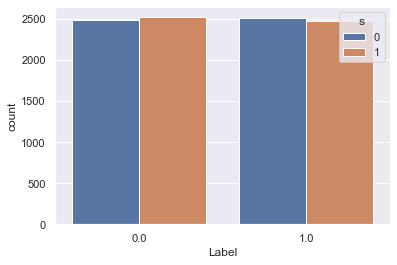

In [3]:
ax = sns.barplot(
    x='10', y='count', 
    hue='s', 
    data=data.groupby('s')['10'].value_counts().rename('count').reset_index(),
)
ax.set(xlabel= 'Label')
plt.show()

The dataset seems to be fair with respect to the sensitive attribute

In [4]:
unprivileged_group = [{'s': 0}]
privileged_group = [{'s': 1}]

# Unbias dataset

Here we will apply the metrics and the algorithms defined above on the unbias version of the dataset and compare how these bias mitigation algorithms change the different metrics.

## Bias metrics

Here we train and test a _Logistic Regression_ classifier:

### Dataset Metrics:

Disparate Impact: 1.0162
Statistical Parity: 0.0080




### Classification Metrics:

Balanced accuracy: 0.7624
Statistical parity difference: 0.0161
Disparate impact: 1.0312
Average odds difference: 0.0120
Equal opportunity difference: 0.0171
Theil index: 0.1485


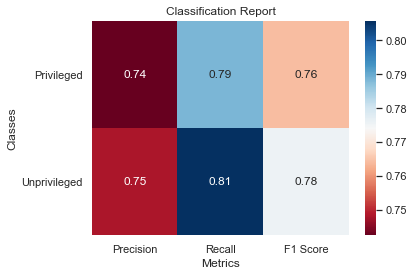

In [5]:
bin_data = BinaryLabelDataset(df=data, protected_attribute_names=['s'], label_names=['10'])

class_metrics = classify(
    make_pipeline(
        StandardScaler(),
        LogisticRegression(class_weight='balanced', solver='liblinear')),
    bin_data, privileged_group, unprivileged_group)

From the values of the metrics we can see that the classifier is fair and quite accurate. Let's now test the same metrics on a bias dataset.

## Reweighing

Here we apply the _Reweighing_ algorithm to the unbiased dataset and see how this method impacts on the metrics defined above:

In [6]:
rw_unbias_data = bin_data.copy()
rw = Reweighing(unprivileged_group, privileged_group)
#rw_unbias_data = rw.fit_transform(rw_unbias_data)

In [7]:
#np.unique(rw_unbias_data.instance_weights)

In [8]:
#sns.violinplot(data=rw_unbias_data.instance_weights)
#plt.show()

### Dataset metrics

In [9]:
#metrics = compute_dataset_fairness_metrics(rw_unbias_data, unprivileged_group, privileged_group)

### Classification metrics

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: 0.0000




### Classification Metrics:

Balanced accuracy: 0.7637
Statistical parity difference: 0.0040
Disparate impact: 1.0086
Average odds difference: 0.0042
Equal opportunity difference: 0.0077
Theil index: 0.1472


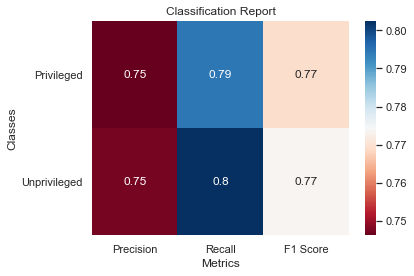

In [10]:
rw_un_metrics = classify(
    make_pipeline(
        StandardScaler(),
        LogisticRegression(class_weight='balanced', solver='liblinear')),
    rw_unbias_data, privileged_group, unprivileged_group, debiaser=rw)

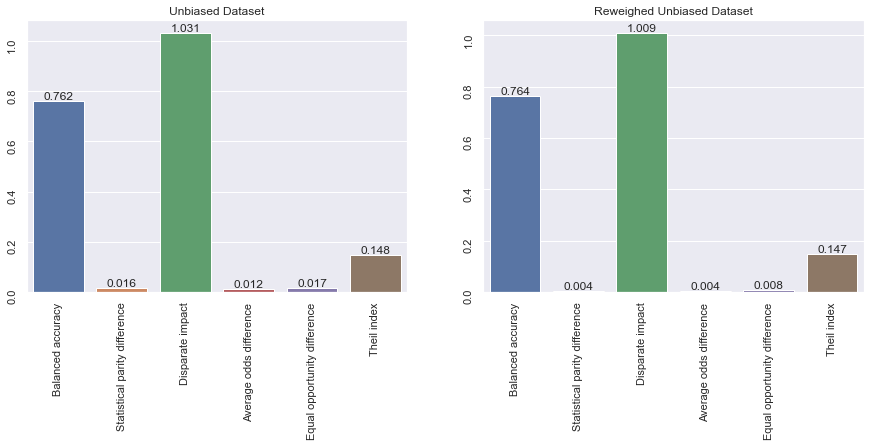

In [11]:
plot_metrics_comparison(class_metrics, rw_un_metrics, "Unbiased Dataset", "Reweighed Unbiased Dataset")
plt.show()

## Disparate Impact Remover

Here we apply the _Disparate Impact Remover_ algorithm to the unbiased dataset and see how this method impacts on the metrics defined above:

In [12]:
dir_unb_data = bin_data.copy()
scaler = MinMaxScaler(copy=False)
dir_unb_data.features = scaler.fit_transform(dir_unb_data.features)

In [13]:
#plot_correlation(dir_unb_data, 's')
#plt.show()

In [14]:
di = DisparateImpactRemover(sensitive_attribute='s')
#dir_unb_data = di.fit_transform(dir_unb_data)

### Dataset metrics

In [15]:
#metrics = compute_dataset_fairness_metrics(dir_unb_data, unprivileged_group, privileged_group)

### Classification metrics

### Dataset Metrics:

Disparate Impact: 1.0162
Statistical Parity: 0.0080




### Classification Metrics:

Balanced accuracy: 0.7620
Statistical parity difference: 0.0115
Disparate impact: 1.0233
Average odds difference: 0.0072
Equal opportunity difference: 0.0108
Theil index: 0.1575


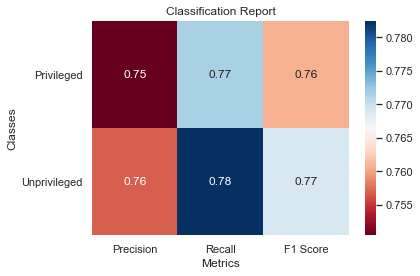

In [16]:
dir_fair_metrics = classify(
    make_pipeline(StandardScaler(),
                  LogisticRegression(class_weight='balanced', solver='liblinear')),
    dir_unb_data, privileged_group, unprivileged_group, sensitive_attributes=['s'], debiaser=di)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


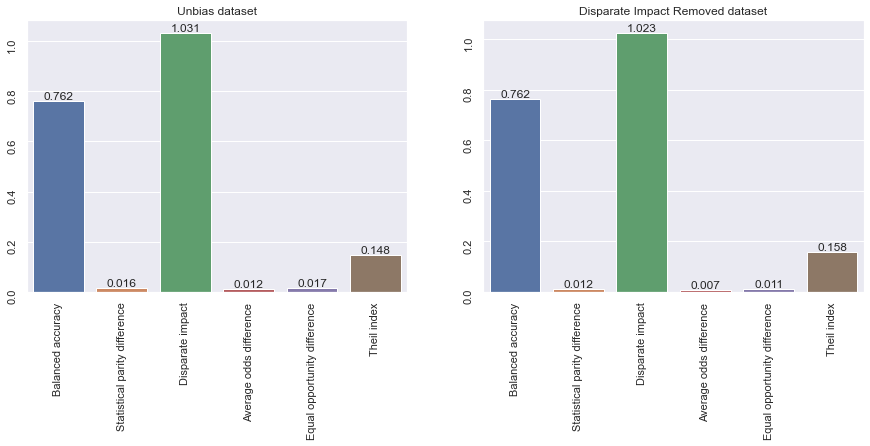

In [17]:
plot_metrics_comparison(class_metrics, dir_fair_metrics, "Unbias dataset", "Disparate Impact Removed dataset")
plt.show()

## Modified Reweighing (Sampling)

In [22]:
unb_sample_ds = bin_data.copy()
sampler = Sampler(round_level=2)

### Classification Metrics

### Dataset Metrics:

Disparate Impact: 1.0088
Statistical Parity: 0.0044




### Classification Metrics:

Balanced accuracy: 0.7610
Statistical parity difference: 0.0088
Disparate impact: 1.0177
Average odds difference: 0.0088
Equal opportunity difference: 0.0144
Theil index: 0.1491


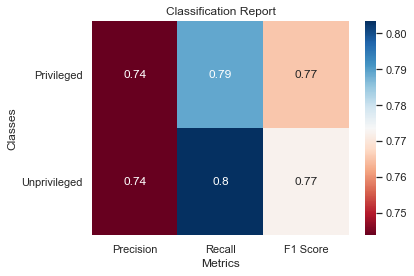

In [23]:
unb_sample_metrics = classify(
    make_pipeline(StandardScaler(),
                  LogisticRegression(class_weight='balanced', solver='liblinear')), 
                  unb_sample_ds, privileged_group, unprivileged_group, debiaser=sampler)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


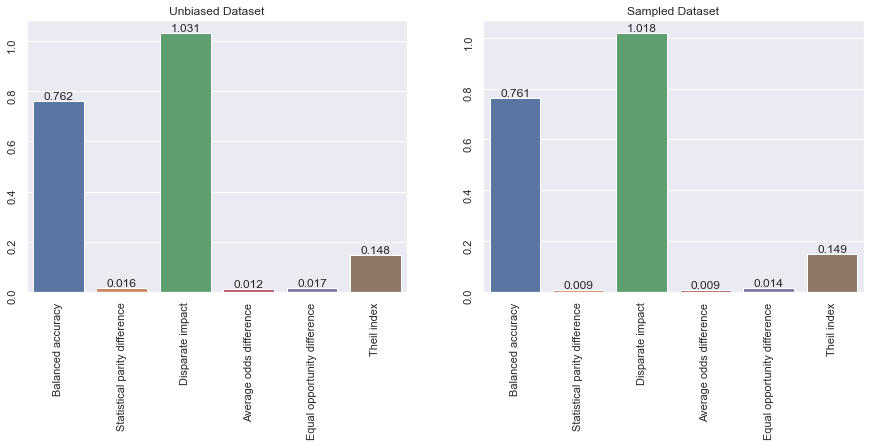

In [24]:
plot_metrics_comparison(class_metrics, unb_sample_metrics, 'Unbiased Dataset', 'Sampled Dataset')
plt.show()

## Reweighing vs Disparate Impact Remover vs Sampling

In the following we compare the performances of _Reweighing_ and _Disparate Impact Remover_ on the unbias dataset. 

In [25]:
un_merged_metrics = merge_datasets({
    'Unbias Data': class_metrics,
    'Reweighed': rw_un_metrics,
    'Sampled Dataset': unb_sample_metrics,
    'Disparate Impact Removed': dir_fair_metrics
})

metrics,Average odds difference,Balanced accuracy,Disparate impact,Equal opportunity difference,Statistical parity difference,Theil index
Dataset,,,,,,
Disparate Impact Removed,0.0072,0.7620,1.0233,0.0108,0.0115,0.1575
Reweighed,0.0042,0.7637,1.0086,0.0077,0.0040,0.1472
Sampled Dataset,0.0088,0.7610,1.0177,0.0144,0.0088,0.1491
Unbias Data,0.0120,0.7624,1.0312,0.0171,0.0161,0.1485


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


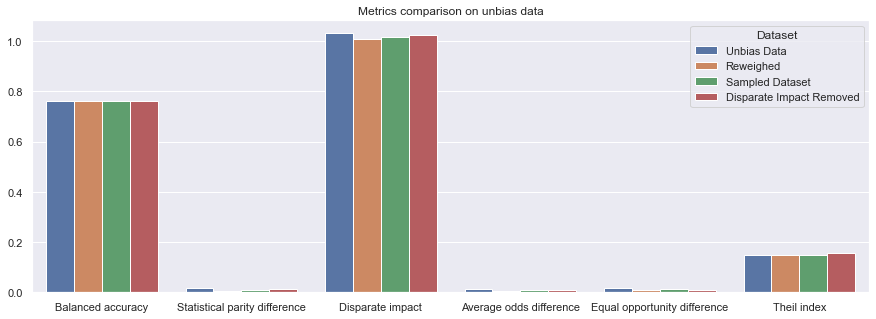

In [26]:
plot_syntesis(un_merged_metrics, 'Metrics comparison on unbias data')
plt.show()

# Unbalanced Bias dataset

Let's change the previous dataset adding a bias on the sensitive attribute `s` with value 0 and keeping the instances with `s=1` invariate:

In [27]:
bias_data = data.copy()
bias_data.loc[(bias_data['s'] == 0) & (bias_data.index < int(len(data)/2)) , '10'] = 0.0

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


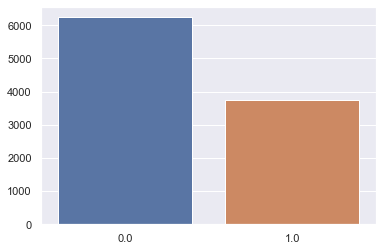

In [28]:
sns.barplot(x=bias_data['10'].value_counts().index, y=bias_data['10'].value_counts().values)
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


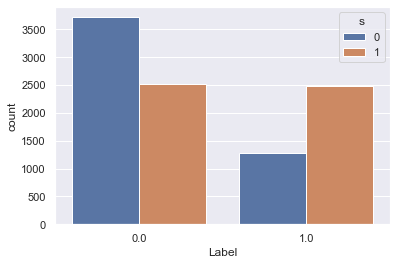

In [29]:
ax = sns.barplot(
    x='10', y='count', 
    hue='s', 
    data=bias_data.groupby('s')['10'].value_counts().rename('count').reset_index(),
)
ax.set(xlabel= 'Label')
plt.show()

Let's compute the dataset fairness metrics on this new dataset:

In [30]:
bias_data_bin = BinaryLabelDataset(df = bias_data, label_names=['10'], protected_attribute_names=['s'])

### Dataset Metrics:

Disparate Impact: 0.5174
Statistical Parity: -0.2392




### Classification Metrics:

Balanced accuracy: 0.7254
Statistical parity difference: -0.3975
Disparate impact: 0.3999
Average odds difference: -0.3534
Equal opportunity difference: -0.5140
Theil index: 0.1502


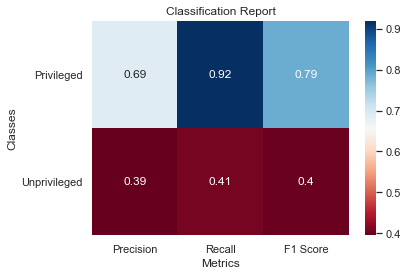

In [31]:
bias_class_metrics = classify(
    make_pipeline(StandardScaler(), 
                  LogisticRegression(class_weight='balanced', solver='liblinear')), 
                  bias_data_bin, privileged_group, unprivileged_group)

##  Reweighing

In [32]:
rw_data = bias_data_bin.copy(deepcopy=True)
rw = Reweighing(unprivileged_group, privileged_group)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.7120
Statistical parity difference: 0.0343
Disparate impact: 1.0749
Average odds difference: 0.0089
Equal opportunity difference: -0.0921
Theil index: 0.1435


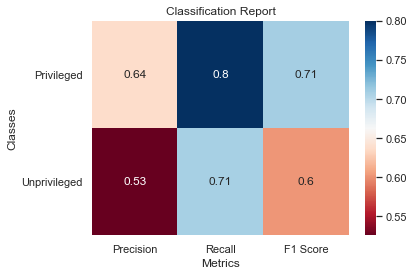

In [33]:
rw_class_metrics = classify(make_pipeline(StandardScaler(), 
                                          LogisticRegression(class_weight='balanced', solver='liblinear')), 
                            rw_data, privileged_group, unprivileged_group, debiaser=rw)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


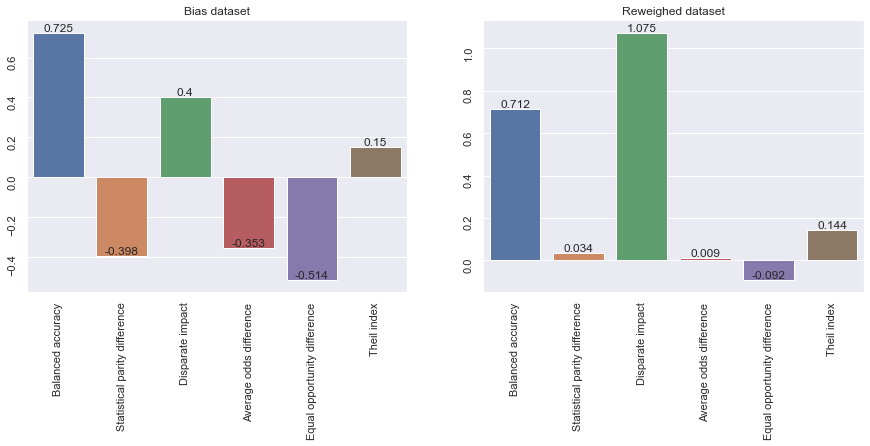

In [34]:
plot_metrics_comparison(bias_class_metrics, rw_class_metrics, "Bias dataset", "Reweighed dataset")
plt.show()

## Disparate Impact Remover

In [35]:
dir_data = bias_data_bin.copy()
scaler = MinMaxScaler(copy=False)
dir_data.features = scaler.fit_transform(dir_data.features)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


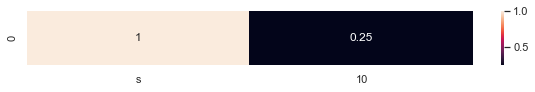

In [36]:
plot_correlation(dir_data, 's')
plt.show()

In [37]:
dr = DisparateImpactRemover(sensitive_attribute='s')
#dir_data = dr.fit_transform(dir_data)

### Dataset Metrics:

Disparate Impact: 0.5173
Statistical Parity: -0.2392




### Classification Metrics:

Balanced accuracy: 0.6941
Statistical parity difference: 0.0021
Disparate impact: 1.0060
Average odds difference: 0.0788
Equal opportunity difference: -0.0042
Theil index: 0.1724


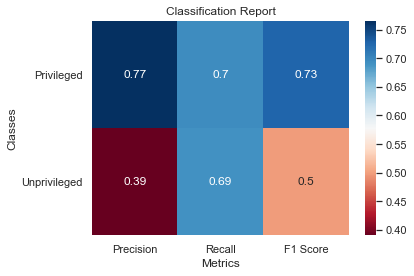

In [38]:
dir_class_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced',solver='liblinear')), 
    dir_data, privileged_group, unprivileged_group,sensitive_attributes=['s'], debiaser=dr)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


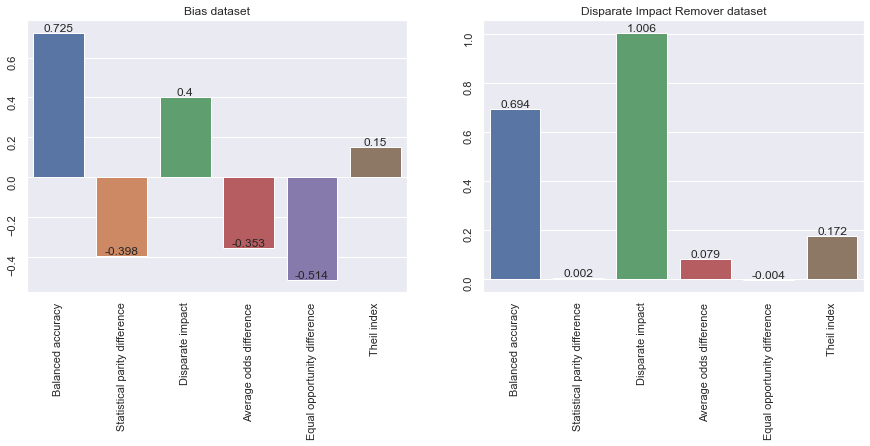

In [39]:
plot_metrics_comparison(bias_class_metrics, dir_class_metrics, "Bias dataset", "Disparate Impact Remover dataset")
plt.show()

## Modified Reweighing (Sampling)

In [42]:
sampled_bias_data = bias_data_bin.copy()
sampler = Sampler(round_level=2)

### Dataset Metrics:

Disparate Impact: 0.9882
Statistical Parity: -0.0045




### Classification Metrics:

Balanced accuracy: 0.7108
Statistical parity difference: 0.0314
Disparate impact: 1.0701
Average odds difference: 0.0075
Equal opportunity difference: -0.0921
Theil index: 0.1495


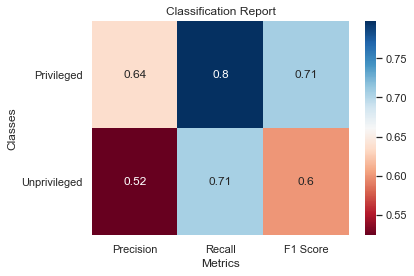

In [43]:
sample_bias_metrics = classify(make_pipeline(StandardScaler(), 
                                             LogisticRegression(class_weight='balanced', solver='liblinear')), 
                               sampled_bias_data, privileged_group, unprivileged_group, debiaser=sampler)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


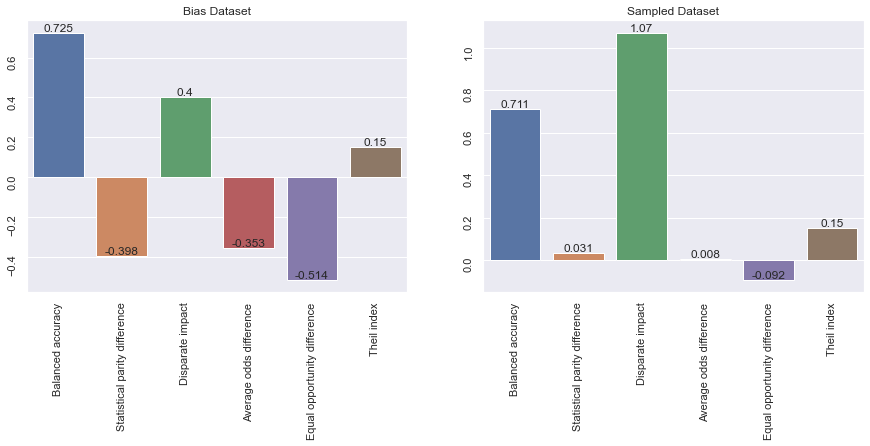

In [44]:
plot_metrics_comparison(bias_class_metrics, sample_bias_metrics, 'Bias Dataset', 'Sampled Dataset')
plt.show()

## Reweighing vs Disparate Impact Remover vs Sampling

In [45]:
unbal_merged_metrics = merge_datasets({
    'Bias unbalanced data':  bias_class_metrics,
    'Reweighed': rw_class_metrics,
    'Sampled Dataset': sample_bias_metrics,
    'Disparate Impact Removed': dir_class_metrics
})

metrics,Average odds difference,Balanced accuracy,Disparate impact,Equal opportunity difference,Statistical parity difference,Theil index
Dataset,,,,,,
Bias unbalanced data,-0.3534,0.7254,0.3999,-0.5140,-0.3975,0.1502
Disparate Impact Removed,0.0788,0.6941,1.0060,-0.0042,0.0021,0.1724
Reweighed,0.0089,0.7120,1.0749,-0.0921,0.0343,0.1435
Sampled Dataset,0.0075,0.7108,1.0701,-0.0921,0.0314,0.1495


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


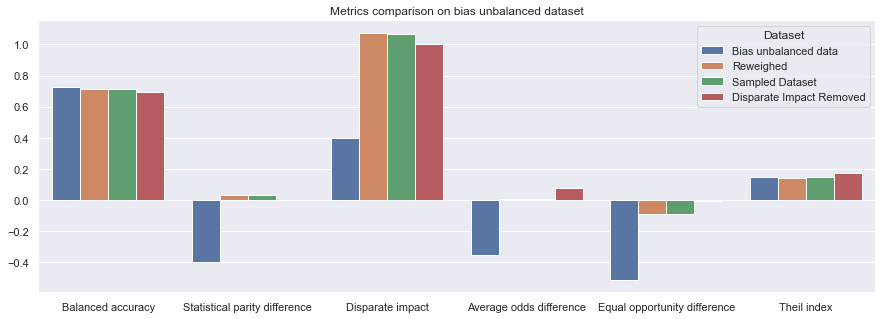

In [46]:
plot_syntesis(unbal_merged_metrics, 'Metrics comparison on bias unbalanced dataset')
plt.show()

# Bias balanced dataset

Let's balance the previous dataset changing the labels of half of the samples with `s=1` to `1.0`

In [47]:
bias_bal_data = bias_data.copy()
bias_bal_data.loc[(bias_data['s'] == 1) & (bias_data.index < int(len(data)/2)) & (bias_data['10']==0.0) , '10'] = 1.0

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


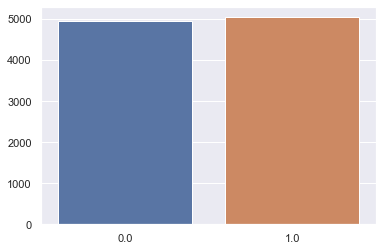

In [48]:
sns.barplot(x=bias_bal_data['10'].value_counts().index, y=bias_bal_data['10'].value_counts().values)
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


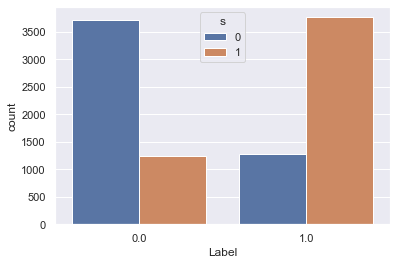

In [49]:
ax = sns.barplot(
    x='10', y='count', 
    hue='s', 
    data=bias_bal_data.groupby('s')['10'].value_counts().rename('count').reset_index(),
)
ax.set(xlabel= 'Label')
plt.show()

In [50]:
bias_bal_bin = BinaryLabelDataset(df=bias_bal_data, label_names=['10'], protected_attribute_names=['s'])

### Dataset Metrics:

Disparate Impact: 0.3406
Statistical Parity: -0.4964




### Classification Metrics:

Balanced accuracy: 0.7421
Statistical parity difference: -0.8872
Disparate impact: 0.0416
Average odds difference: -0.8581
Equal opportunity difference: -0.8921
Theil index: 0.1900


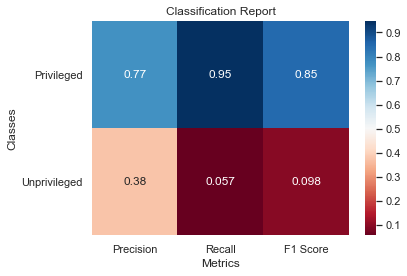

In [51]:
bias_bal_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    bias_bal_bin, privileged_group, unprivileged_group)

## Reweighing

In [52]:
rw_bal = bias_bal_bin.copy()
rw = Reweighing(unprivileged_group, privileged_group)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: 0.0000




### Classification Metrics:

Balanced accuracy: 0.6683
Statistical parity difference: 0.0301
Disparate impact: 1.0604
Average odds difference: 0.0301
Equal opportunity difference: 0.0248
Theil index: 0.2149


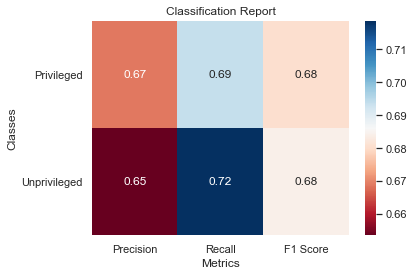

In [53]:
rw_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    rw_bal, privileged_group, unprivileged_group, debiaser=rw)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


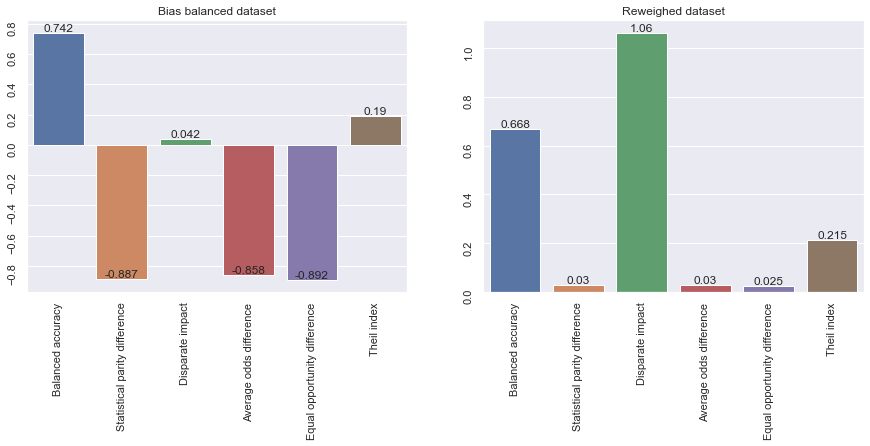

In [54]:
plot_metrics_comparison(bias_bal_metrics, rw_metrics, 'Bias balanced dataset', 'Reweighed dataset')
plt.show()

## Modified Reweighing (Sampling)

In [55]:
bias_sample_ds = bias_bal_bin.copy()
sampler = Sampler(round_level=2)

### Dataset Metrics:

Disparate Impact: 0.9906
Statistical Parity: -0.0048




### Classification Metrics:

Balanced accuracy: 0.6652
Statistical parity difference: 0.0200
Disparate impact: 1.0396
Average odds difference: 0.0209
Equal opportunity difference: 0.0027
Theil index: 0.2137


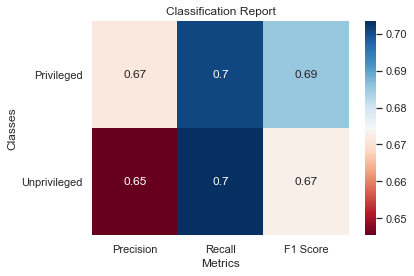

In [56]:
sampling_metrics = classify(make_pipeline(
    StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
                            bias_sample_ds, privileged_group, unprivileged_group, debiaser=sampler)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


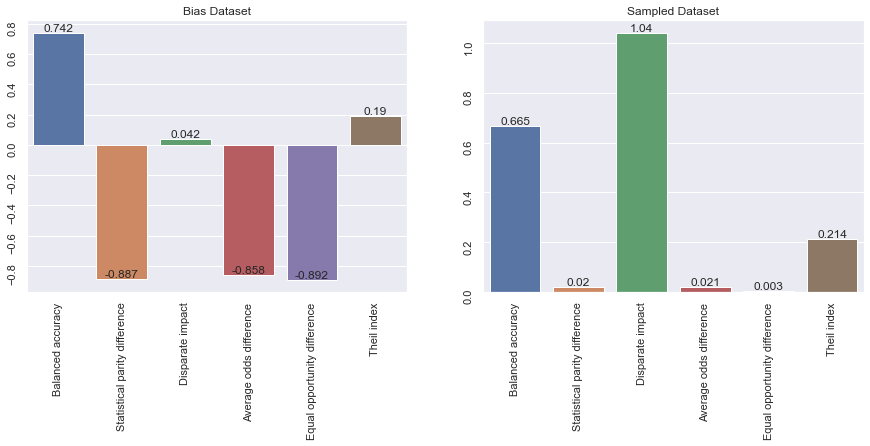

In [58]:
plot_metrics_comparison(bias_bal_metrics, sampling_metrics, 'Bias Dataset', 'Sampled Dataset')
plt.show()

## Disparate Impact Remover

In [59]:
dir_bal = bias_bal_bin.copy()
scaler = MinMaxScaler()
dir_bal.features = scaler.fit_transform(dir_bal.features)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


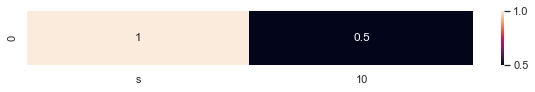

In [60]:
plot_correlation(dir_bal, 's')
plt.show()

In [61]:
dr = DisparateImpactRemover(sensitive_attribute='s')
#dir_bal = dr.fit_transform(dir_bal)

### Dataset Metrics:

Disparate Impact: 0.3406
Statistical Parity: -0.4964




### Classification Metrics:

Balanced accuracy: 0.6250
Statistical parity difference: 0.0103
Disparate impact: 1.0204
Average odds difference: 0.1783
Equal opportunity difference: 0.1847
Theil index: 0.2526


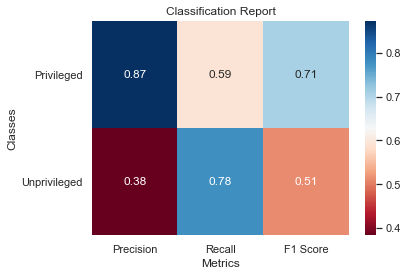

In [62]:
dir_score = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    dir_bal, privileged_group, unprivileged_group, sensitive_attributes=['s'], debiaser=dr)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


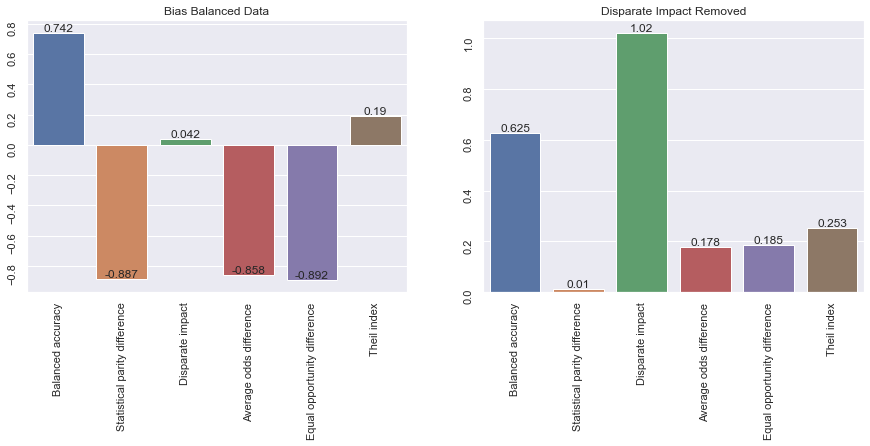

In [63]:
plot_metrics_comparison(bias_bal_metrics, dir_score, 'Bias Balanced Data', 'Disparate Impact Removed')
plt.show()

## Reweighing vs Disparate Impact Remover vs Sampling

In [66]:
bal_merged_metrics = merge_datasets({
    'Bias Balanced Data': bias_bal_metrics,
    'Reweighed': rw_metrics,
    'Sampled Dataset': sampling_metrics,
    'Disparate Impact Removed': dir_score
})

metrics,Average odds difference,Balanced accuracy,Disparate impact,Equal opportunity difference,Statistical parity difference,Theil index
Dataset,,,,,,
Bias Balanced Data,-0.8581,0.7421,0.0416,-0.8921,-0.8872,0.1900
Disparate Impact Removed,0.1783,0.6250,1.0204,0.1847,0.0103,0.2526
Reweighed,0.0301,0.6683,1.0604,0.0248,0.0301,0.2149
Sampled Dataset,0.0209,0.6652,1.0396,0.0027,0.0200,0.2137


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


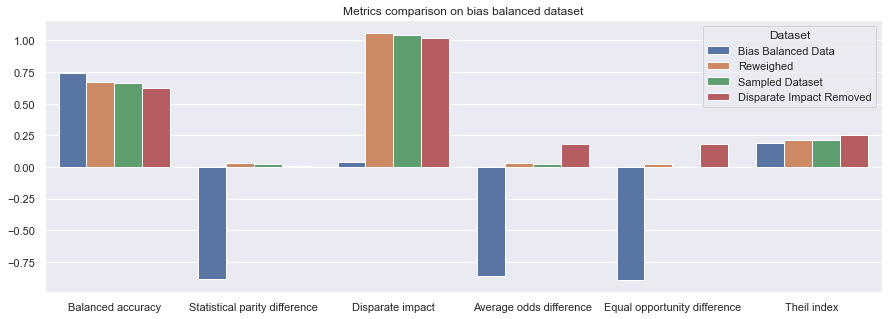

In [67]:
plot_syntesis(bal_merged_metrics, 'Metrics comparison on bias balanced dataset')
plt.show()

# Comparison of the three datasets

Here we compare the metrics for the three versions of the dataset and the methods applied:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


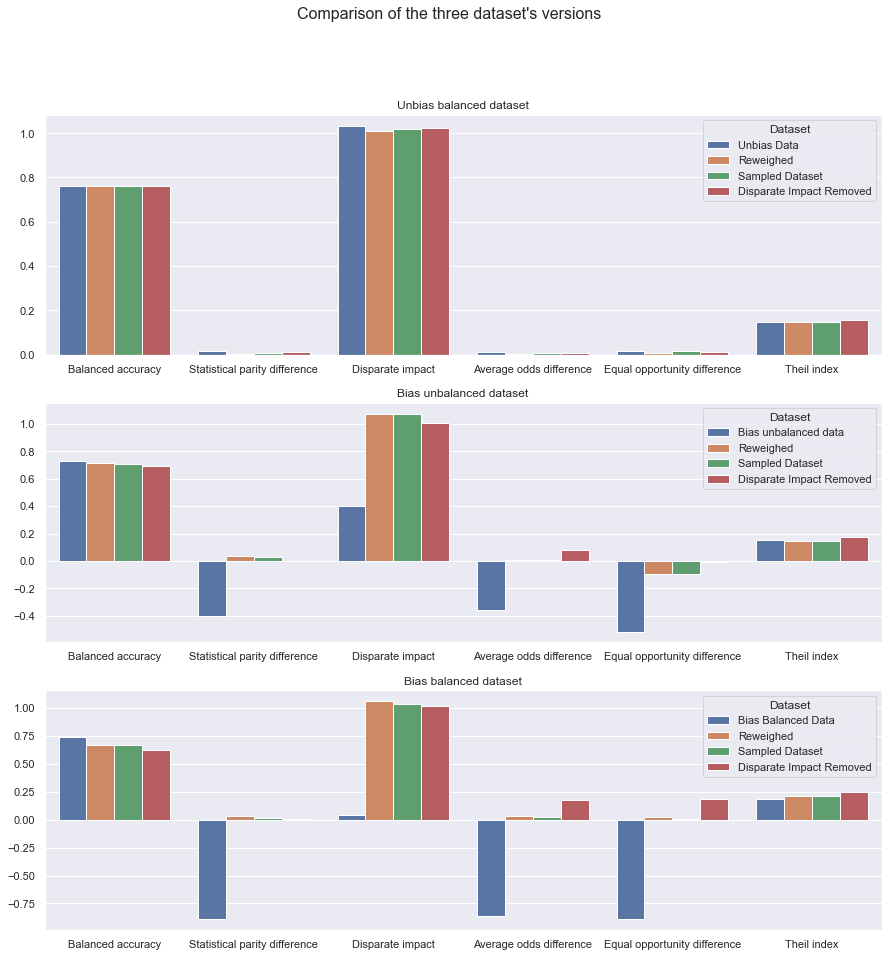

In [68]:
fig, axes = plt.subplots(3,1,figsize=(15,15))
sns.barplot(data=un_merged_metrics, x='metrics', y='values', hue='Dataset',ax=axes[0],)
sns.barplot(data=unbal_merged_metrics, x='metrics', y='values', hue='Dataset',ax=axes[1])
sns.barplot(data=bal_merged_metrics, x='metrics', y='values', hue='Dataset',ax=axes[2])
for ax in axes:
    ax.set(xlabel='', ylabel='')
axes[0].set_title('Unbias balanced dataset')
axes[1].set_title('Bias unbalanced dataset')
axes[2].set_title('Bias balanced dataset')
fig.suptitle("Comparison of the three dataset's versions", fontsize=16)
plt.show()

# Combine Reweighing and DIR

As can be seen from the charts above both RW and DIR performs well in mitigating the unfairness of the classifier. However both have some lacks:

1. Reweighing requires that a classifier takes account of instance weights, but not all the classifier models do so
2. Disparate Impact Remover has no effect on the dataset fairness metrics but only on the classifier metrics

To solve these problems we will now try to combine these two algorithms by applying the instance weights to the DIR modified dataset and see the results.

## Test with unbias data

In [69]:
un_rw_dir = dir_unb_data.copy(deepcopy=True)
rw = Reweighing(unprivileged_group, privileged_group)
un_rw_dir = rw.fit_transform(un_rw_dir)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: 0.0000




### Classification Metrics:

Balanced accuracy: 0.7638
Statistical parity difference: -0.0068
Disparate impact: 0.9890
Average odds difference: -0.0071
Equal opportunity difference: -0.0063
Theil index: 0.1478


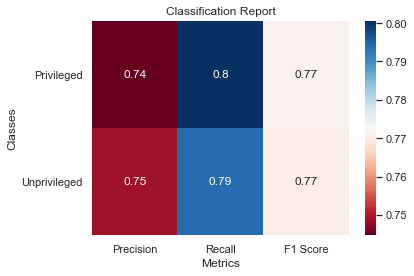

In [70]:
unb_rw_dir_score = classify(make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
                            un_rw_dir, privileged_group, unprivileged_group, sensitive_attributes=['s'])

### Comparison

In [84]:
un_rw_dir_merg =  merge_datasets({
    'Unbias Data': class_metrics,
    'Reweighed': rw_un_metrics,
    'Disparate Impact Removed': dir_fair_metrics,
    'Sampling': unb_sample_metrics,
    'RW + DIR': unb_rw_dir_score
})

metrics,Average odds difference,Balanced accuracy,Disparate impact,Equal opportunity difference,Statistical parity difference,Theil index
Dataset,,,,,,
Disparate Impact Removed,0.0072,0.7620,1.0233,0.0108,0.0115,0.1575
RW + DIR,-0.0071,0.7638,0.9890,-0.0063,-0.0068,0.1478
Reweighed,0.0042,0.7637,1.0086,0.0077,0.0040,0.1472
Sampling,0.0088,0.7610,1.0177,0.0144,0.0088,0.1491
Unbias Data,0.0120,0.7624,1.0312,0.0171,0.0161,0.1485


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


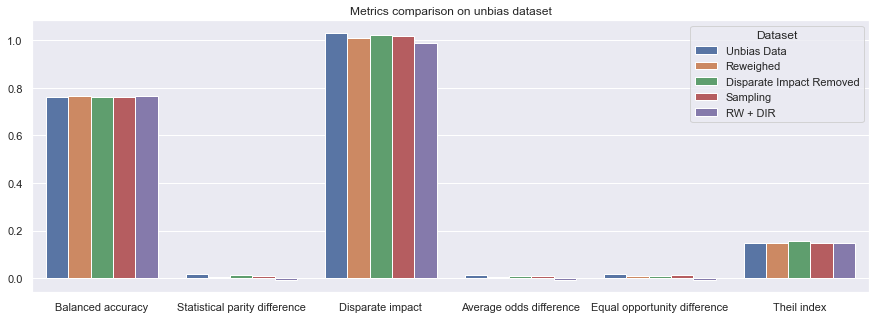

In [85]:
plot_syntesis(un_rw_dir_merg, 'Metrics comparison on unbias dataset')
plt.show()

## Test with unbalance bias data

In [73]:
unbal_dir_rw_data = dir_data.copy()
rw = Reweighing(unprivileged_group, privileged_group)
unbal_dir_rw_data = rw.fit_transform(unbal_dir_rw_data)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.7152
Statistical parity difference: 0.1003
Disparate impact: 1.2291
Average odds difference: 0.0801
Equal opportunity difference: -0.0012
Theil index: 0.1468


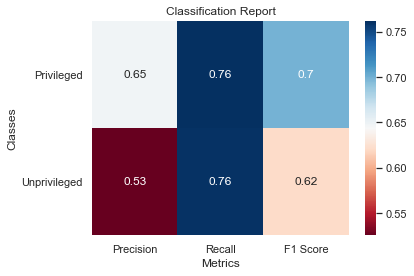

In [74]:
rw_dir_score = classify(make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
                            unbal_dir_rw_data, privileged_group, unprivileged_group, sensitive_attributes=['s'])

In [88]:
unbal_rw_dir_score = merge_datasets({
    'Bias unbalanced data':  bias_class_metrics,
    'Reweighed': rw_class_metrics,
    'Disparate Impact Removed': dir_class_metrics,
    'Sampling': sample_bias_metrics,
    'RW + DIR': rw_dir_score
})

### Comparison

metrics,Average odds difference,Balanced accuracy,Disparate impact,Equal opportunity difference,Statistical parity difference,Theil index
Dataset,,,,,,
Bias unbalanced data,-0.3534,0.7254,0.3999,-0.5140,-0.3975,0.1502
Disparate Impact Removed,0.0788,0.6941,1.0060,-0.0042,0.0021,0.1724
RW + DIR,0.1700,0.6757,1.3734,0.1768,0.1698,0.2331
Reweighed,0.0089,0.7120,1.0749,-0.0921,0.0343,0.1435
Sampling,0.0075,0.7108,1.0701,-0.0921,0.0314,0.1495


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


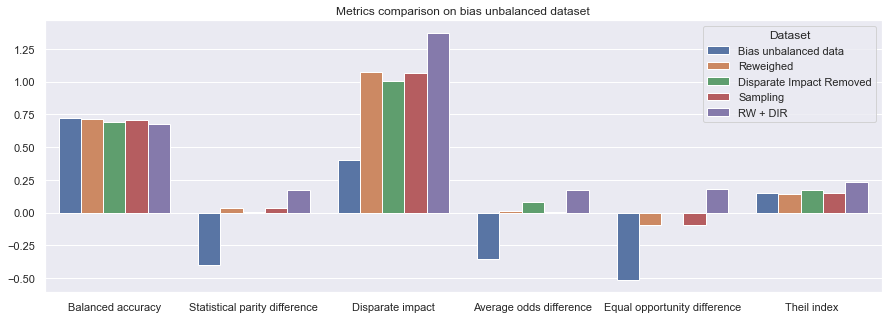

In [89]:
plot_syntesis(unbal_rw_dir_score, 'Metrics comparison on bias unbalanced dataset')
plt.show()

## Test with balanced bias data

In [77]:
dir_rw_data = dir_bal.copy()
rw = Reweighing(unprivileged_group, privileged_group)
dir_rw_data = rw.fit_transform(dir_rw_data)

In [78]:
score = compute_dataset_fairness_metrics(dir_rw_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.6757
Statistical parity difference: 0.1698
Disparate impact: 1.3734
Average odds difference: 0.1700
Equal opportunity difference: 0.1768
Theil index: 0.2331


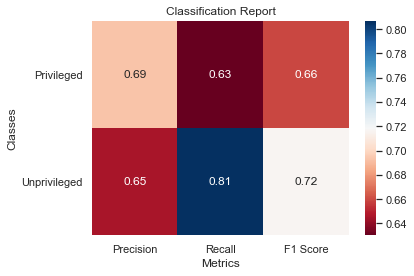

In [79]:
rw_dir_score = classify(make_pipeline(StandardScaler(),LogisticRegression(class_weight='balanced', solver='liblinear')),
                        dir_rw_data, privileged_group, unprivileged_group, sensitive_attributes=['s'])

In [90]:
rw_dir_merged_metrics = merge_datasets({
    'Bias Balanced Data': bias_bal_metrics,
    'Reweighed': rw_metrics,
    'Disparate Impact Removed': dir_score,
    'Sampling': sampling_metrics,
    'RW + DIR': rw_dir_score
})

### Comparison

metrics,Average odds difference,Balanced accuracy,Disparate impact,Equal opportunity difference,Statistical parity difference,Theil index
Dataset,,,,,,
Bias Balanced Data,-0.8581,0.7421,0.0416,-0.8921,-0.8872,0.1900
Disparate Impact Removed,0.1783,0.6250,1.0204,0.1847,0.0103,0.2526
RW + DIR,0.1700,0.6757,1.3734,0.1768,0.1698,0.2331
Reweighed,0.0301,0.6683,1.0604,0.0248,0.0301,0.2149
Sampling,0.0209,0.6652,1.0396,0.0027,0.0200,0.2137


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


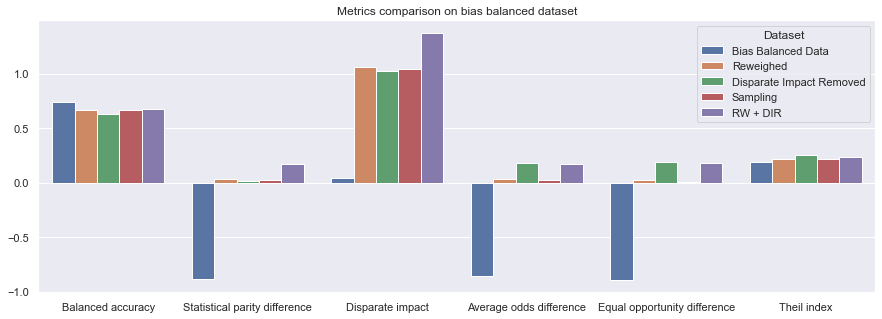

In [91]:
plot_syntesis(rw_dir_merged_metrics, 'Metrics comparison on bias balanced dataset')
plt.show()